# Convolutional Filter Factorization
In this notebook, I want to see if we can factorize a spatial filter with large support into successive convolutions of filters with smaller spatial support. The inspiration for this comes from the fact that I often have to work with large spatial kernels, and there may be some speedup available by using successive smaller convolutions. 

For example lots of 5x5 kernels can be made up of 2 3x3 convolutions, using 18 multiply/adds per pixel instead of 25. Of course, there are some that cannot be made up from 2 3x3 convolutions, but perhaps we are happy to pay a small error term. 

Further, when viewing nvidia-prof profiling outputs, it seems that if we use 3x3 convolutions, these are done using winograd rather than fft/ifft lowlevel kernels. I wouldn't be surprised if due to the large prevalence of 3x3 kernels in the machine learning literature, that GPUs are being specifically optimized for them.

In [12]:
# Import my plotting libraries. plotters is available at 
# https://github.com/fbcotter/plotters
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['image.resample'] = False
mpl.rcParams['image.interpolation'] = 'none'
mpl.rcParams['image.cmap'] = 'gray'
import matplotlib.pyplot as plt
import plotters

# Import my numeric libraries. Pytorch wavelets is a library that allows
# the dtcwt kernels (the particular ones I want to speed up) to be done in
# pytorch (and optionally, with a GPU). 
import numpy as np
import torch
import torch.nn.functional as F
import dtcwt
from pytorch_wavelets import DTCWTForward, DTCWTInverse
from pytorch_wavelets.dtcwt.lowlevel import q2c
dev = torch.device('cpu')

# Get the target filters
This next bit of code is largely specific to my task. Any filters here would suffice. For our example, I'm looking at the synthesis filters of a single layer inverse Dual Tree Complex Wavelet Transform. They are 7x7 but have little energy in the outermost pixels.

<IPython.core.display.Javascript object>


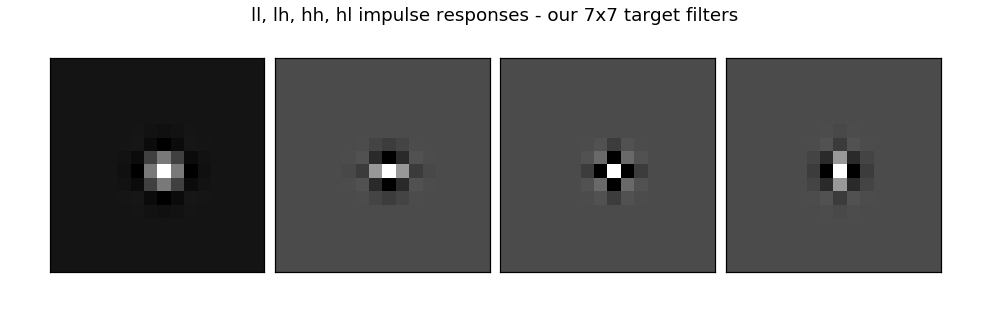

In [2]:
ifm = DTCWTInverse(J=1, biort='near_sym_a', qshift='qshift_a')

def yb_to_yh(yb):
    # Converts the 6 complex bands back into the 3 LH, HH, HL bands
    deg15, deg165 = q2c(yb[:,0])
    deg45, deg135 = q2c(yb[:,1])
    deg75, deg105 = q2c(yb[:,2])
    yh = torch.stack((deg15, deg45, deg75, deg105, deg135, deg165), dim=2)
    return yh

# Create an output array to store the results
xb = np.zeros((4,16,16))
yl = torch.zeros(1,1,16,16)
yb = torch.zeros(1,3,1,16,16)

# Put impulses in the ll, lh, hh and hl bands
yl[0,0,8,8] = 1
x = ifm((yl, [yb_to_yh(yb)]))
xb[0] = x.detach().cpu().numpy()[0,0]
yl[0,0,8,8] = 0
for b in range(3):
    yb[0,b,0,8,8] = 1
    x = ifm((yl, [yb_to_yh(yb)]))
    xb[b+1] = x.detach().cpu().numpy()[0,0]
    yb[0,b] = 0
    
# Plot the resulting outputs
fig, ax = plt.subplots(1,4, figsize=(9,3), 
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw={'top':0.95, 'bottom':0.05, 'left':0.05, 
                                    'right':0.95, 'wspace':0.05})
for i in range(4):
    ax[i].imshow(xb[i])
fig.suptitle('ll, lh, hh, hl impulse responses - our 7x7 target filters');

# Aside 1: Convex vs Non Convex
This is a non convex optimization problem. Consider the simple case where we want to minimize a 1x1 kernel as a convolution of 2 1x1 kernels (I know this is silly, but it makes the maths nicer). Then our output is:
$$
f = xy
$$

To check for convexity, we need the Hessian matrix to be positive semi definite. We know that whenever there is a cross term then the problem cannot be convex, but for simplicity sake, let us check what the Hessian matrix is anyway.
$$
H_{i,j} = \frac{\partial^2f}{\partial x_i \partial x_j}
$$

$$
H = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
$$

Positive semi definite means that for any $x$, $x^THx$ must be greater than or equal to zero for any x. In our above problem, our Hessian is larger than 2 by 2, but there is a nice trick in that every subset of the Hessian must also be PSD (you can set the corresponding parts of $x$ to 0 to ignore the other areas). In the above case, if $x=[-1,1]^T$ gives $x^THx = -2$.

Another nice bit of info for PSD, is that if a matrix is diagonally dominant, i.e.
$$
h_{i,i} \geq \sum_{j \neq i} |h_{i,j}|
$$

and $h_{i,i} \geq 0$, then we have a PSD matrix. This however is sufficient and not necessary. This is often why we sometimes add a small identity matrix to a covariance matrix to make sure we are satisfying its PSD conditions.

# Aside 2: check how to do alternating projections
Non convex optimization is not trivial. A simple way of solving it is to do alternating projections. I.e. minimize w.r.t. x keeping y constant, the minimizing w.r.t. y keeping x constant.
Let us return to the $f=xy$ problem, and try to use pytorch to alternate minimizations. This is an underdetermined set of equations, so let us also add a constraint on the norms of $x$ and $y$. I.e. minimize:

$$
L = (xy - \alpha)^2 + \lambda (|x| + |y|)
$$

As an example, let us try to find two numbers $x$ and $y$ that multiply to give 20, while minimising the $l_1$ norm.

In [3]:
# Randomly initialize x and y to be a gaussian with std 10
x = torch.tensor(10*np.random.randn(1), dtype=torch.float32, requires_grad=True)
y = torch.tensor(10*np.random.randn(1), dtype=torch.float32, requires_grad=True)

# Set the target (α), the lagrangian multiplier (λ) and the learning rate
α = 20
λ = 0.1
lr = 1e-2
N = 20 # Number of steps

# Create two optimizers, one for x and one for y
optimx = torch.optim.SGD([x], lr=lr, momentum=0)
optimy = torch.optim.SGD([y], lr=lr, momentum=0)
for i in range(N):
    # Minimize wrt x
    optimx.zero_grad()
    optimy.zero_grad()
    z = x*y
    l = (z - α)**2 + λ * (torch.abs(x) + torch.abs(y))
    print("Step {:2}a: Loss = {loss:09.4f}\tOut = {out:.2f} ({x:.2f}, {y:.2f})".format(
        i, loss=l.item(), out=z.item(), x=x.item(), y=y.item()))
    l.backward()
    optimx.step()
    
    # Minimize wrt y
    optimx.zero_grad()
    optimy.zero_grad()
    z = x*y
    l = (z - α)**2 + λ * (torch.abs(x) + torch.abs(y))
    print("Step {:2}b: Loss = {loss:09.4f}\tOut = {out:.2f} ({x:.2f}, {y:.2f})".format(
        i, loss=l.item(), out=z.item(), x=x.item(), y=y.item()))
    l.backward()
    optimy.step()

Step  0a: Loss = 0404.3896	Out = -0.10 (0.04, -2.68)
Step  0b: Loss = 0296.7857	Out = 2.78 (-1.04, -2.68)
Step  1a: Loss = 0284.1869	Out = 3.15 (-1.04, -3.03)
Step  1b: Loss = 0189.4539	Out = 6.25 (-2.06, -3.03)
Step  2a: Loss = 0158.8276	Out = 7.42 (-2.06, -3.60)
Step  2b: Loss = 0087.5617	Out = 10.68 (-2.97, -3.60)
Step  3a: Loss = 0059.7771	Out = 12.31 (-2.97, -4.15)
Step  3b: Loss = 0026.1703	Out = 14.96 (-3.60, -4.15)
Step  4a: Loss = 0014.7589	Out = 16.27 (-3.60, -4.51)
Step  4b: Loss = 0005.7598	Out = 17.78 (-3.94, -4.51)
Step  5a: Loss = 0003.2123	Out = 18.47 (-3.94, -4.69)
Step  5b: Loss = 0001.6230	Out = 19.14 (-4.08, -4.69)
Step  6a: Loss = 0001.2203	Out = 19.42 (-4.08, -4.76)
Step  6b: Loss = 0000.9932	Out = 19.68 (-4.14, -4.76)
Step  7a: Loss = 0000.9386	Out = 19.78 (-4.14, -4.78)
Step  7b: Loss = 0000.9088	Out = 19.88 (-4.16, -4.78)
Step  8a: Loss = 0000.9019	Out = 19.92 (-4.16, -4.79)
Step  8b: Loss = 0000.8980	Out = 19.95 (-4.16, -4.79)
Step  9a: Loss = 0000.8972	Out = 

This seems to work nicely. Notice as we step from $n$a to $n$b, only one of the two parameters changes.

Now onwards to the filter factorization!

# Define filters as convolution of 2 3x3
Let us try match the lh, hl and hh wavelets. To make our filters admissable wavelets, we also need to impose the restriction that $\sum_{i,j} w_{i,j} = 0$

In [4]:
# Define our 
w1 = torch.randn(1,1,3,3, requires_grad=True)
w2 = torch.randn(1,1,3,3, requires_grad=True)

# Define the lagrangian for mse, minimum energy coefficients and admissability
λ = 100
λ1 = .1
λ2 = 1
lr = 5e-2
N = 20

# Define our target - we'll start with lh
y = torch.tensor(xb[1], dtype=torch.float32).reshape(1,1,16,16)
# Make it zero mean and unit std
y = (y-y.mean())/y.std()

# Define our two optimizers
optim1 = torch.optim.SGD([w1], lr=lr, momentum=0)
optim2 = torch.optim.SGD([w2], lr=lr, momentum=0)

x = torch.zeros(1,1,16,16)
x[0,0,8,8] = 1
lbest = np.inf
w1_best = w1.data.numpy()
w2_best = w2.data.numpy()

for i in range(N):
    # Minimize wrt w1
    optim1.zero_grad()
    optim2.zero_grad()
    
    y1 = F.conv2d(x, w1, padding=1)
    y2 = F.conv2d(y1, w2, padding=1)
    lmse = λ * torch.mean((y - y2)**2)
    lreg = λ1 * (torch.mean(w1**2) + torch.mean(w2**2))
    ladmiss = λ2 * torch.abs(torch.sum(y2))
    l = lmse + lreg + ladmiss
        
    print("Step {:2}a: Loss = {loss:09.4f}\tMSE: {mse:07.3f}\t " 
          "Reg: {reg:07.3f}\tAdmiss: {adm:07.3f})".format(
              i, loss=l.item(), mse=lmse.item(), reg=lreg.item(), 
              adm=ladmiss.item()))
    l.backward()
    optim1.step()
    
    if l.item() < lbest:
        w1_best = w1.data.numpy()
        w2_best = w2.data.numpy()
        lbest = l.item()
    
    # Minimize wrt w2
    optim1.zero_grad()
    optim2.zero_grad()
    
    y1 = F.conv2d(x, w1, padding=1)
    y2 = F.conv2d(y1, w2, padding=1)
    lmse = λ * torch.mean((y - y2)**2)
    lreg = λ1 * (torch.mean(w1**2) + torch.mean(w2**2))
    ladmiss = λ2 * torch.abs(torch.sum(y2))
    l = lmse + lreg + ladmiss
    
    print("Step {:2}b: Loss = {loss:09.4f}\tMSE: {mse:07.3f}\t "
          "Reg: {reg:07.3f}\tAdmiss: {adm:07.3f})".format(
              i, loss=l.item(), mse=lmse.item(), reg=lreg.item(), 
              adm=ladmiss.item()))
    l.backward()
    optim2.step()
    
    if l.item() < lbest:
        w1_best = w1.data.numpy()
        w2_best = w2.data.numpy()
        lbest = l.item()
    
print('-' * 50)
print('Best loss was {}'.format(lbest))

Step  0a: Loss = 0104.7647	MSE: 103.354	 Reg: 000.168	Admiss: 001.243)
Step  0b: Loss = 0043.8679	MSE: 043.400	 Reg: 000.180	Admiss: 000.288)
Step  1a: Loss = 0022.3645	MSE: 021.798	 Reg: 000.226	Admiss: 000.341)
Step  1b: Loss = 0009.5339	MSE: 008.788	 Reg: 000.252	Admiss: 000.494)
Step  2a: Loss = 0006.9480	MSE: 006.337	 Reg: 000.260	Admiss: 000.351)
Step  2b: Loss = 0003.7069	MSE: 003.242	 Reg: 000.263	Admiss: 000.201)
Step  3a: Loss = 0002.5059	MSE: 002.113	 Reg: 000.263	Admiss: 000.129)
Step  3b: Loss = 0001.6599	MSE: 001.254	 Reg: 000.265	Admiss: 000.141)
Step  4a: Loss = 0001.2352	MSE: 000.890	 Reg: 000.266	Admiss: 000.079)
Step  4b: Loss = 0000.9242	MSE: 000.644	 Reg: 000.267	Admiss: 000.014)
Step  5a: Loss = 0000.7898	MSE: 000.515	 Reg: 000.265	Admiss: 000.009)
Step  5b: Loss = 0000.7030	MSE: 000.419	 Reg: 000.265	Admiss: 000.019)
Step  6a: Loss = 0000.6378	MSE: 000.362	 Reg: 000.265	Admiss: 000.010)
Step  6b: Loss = 0000.5727	MSE: 000.305	 Reg: 000.265	Admiss: 000.003)
Step  

Plot the result

<IPython.core.display.Javascript object>


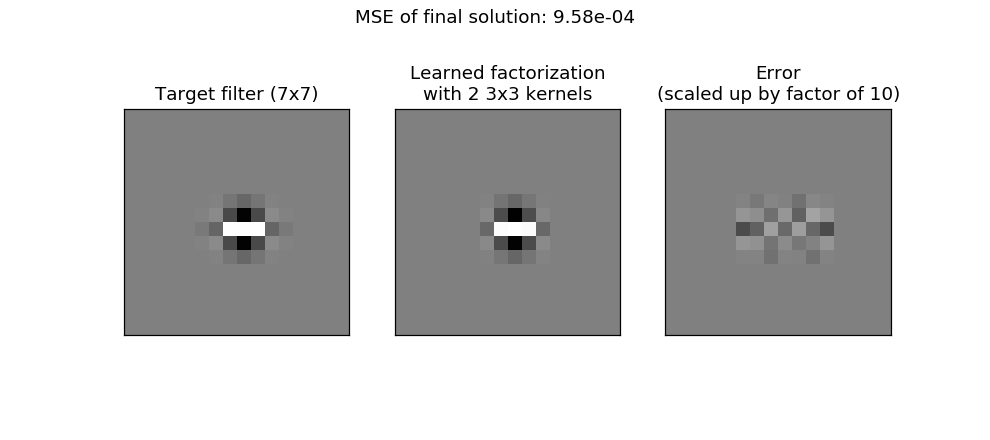

In [5]:
y1 = F.conv2d(x, torch.tensor(w1_best, dtype=torch.float32), padding=1)
y2 = F.conv2d(y1, torch.tensor(w2_best, dtype=torch.float32), padding=1)
y_hat = y2.detach().cpu().numpy()[0,0]
y_target = y.detach().cpu().numpy()[0,0]

fig, ax = plt.subplots(1,3, figsize=(9,4), 
                       subplot_kw={'xticks':[], 'yticks':[]})
ax[0].imshow(y_target, vmin=-5, vmax=5)
ax[0].set_title('Target filter (7x7)')
ax[1].imshow(y_hat, vmin=-5, vmax=5)
ax[1].set_title('Learned factorization\nwith 2 3x3 kernels')
ax[2].imshow(y_target-y_hat, vmin=-.5, vmax=0.5)
im = ax[2].set_title('Error\n(scaled up by factor of 10)')
fig.suptitle('MSE of final solution: {:.2e}'.format(
    np.mean((y_target - y_hat)**2)));

# Run with different initial conditions
This is good, but we want to run it with different random starts and find the best over these

In [6]:
def get_loss(x, y, net, λ, λ1, λ2):
    y_out = net(x)
    
    lmse = λ*torch.mean((y - y_out)**2)
    lreg = λ1 * net.reg_loss()
    ladmiss = λ2 * torch.sum(y_out)**2
    l = lmse + lreg + ladmiss
    return l


class MyNet(torch.nn.Module):
    def __init__(self, k=3, n=2):
        super().__init__()
        self.w = torch.nn.ParameterList([
            torch.nn.Parameter(torch.randn(1,1,k,k)) for _ in range(n)])
        self.n = n
        self.k = k
        
    def reg_loss(self):
        loss = torch.tensor(0., dtype=torch.float)
        for i in range(self.n):
            loss += torch.mean(self.w[i]**2)
        return loss
    
    def accept_weights(self, ws):
        self.w = torch.nn.ParameterList([
               torch.nn.Parameter(
                   torch.tensor(w, dtype=torch.float32), requires_grad=False) 
            for w in ws
        ])
        self.n = len(ws)
        self.k = ws[0].shape[-1]
    
    def forward(self, X):
        for i in range(self.n):            
            X = F.conv2d(X, self.w[i], padding=(self.k//2))
        return X
    
        
def find_ws(x, target, k=3, n=2, runs=50, iters=50, λ=5000, λ1=0.1, λ2=1, lr=5e-3):
    """ Matches a target filter by convolving n smaller filters
    
    Args:
        x: the impulse input
        target: target filter
        k: kernel size of smaller filter
        n: number of successive smaller filters to use
        runs: number of random starts
        iters: number of steps per random start
        λ: MSE lagrange multiplier
        λ1: Regularization lagrange multiplier
        λ2: Admissibility lagrange multiplier
    """
    if np.abs(target.sum()) > 1e-6 and λ2 > 0:
        print('Warning: the admissibility gain is non zero but the target is '
              'itself not admissible')
        
    bestw = [np.zeros((1,1,k,k), dtype='float32') for _ in range(n)]    
    
    y = torch.tensor(target, dtype=torch.float32, device=dev)  
    if len(y.shape) == 2:
        y = torch.unsqueeze(torch.unsqueeze(y, dim=0), dim=0)
    # Make the target 0 mean and unit std
    y = (y-y.mean())/y.std()
    
    x = torch.tensor(x, dtype=torch.float32, device=dev)
    if len(x.shape) == 2:
        x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=0)    
    lbest = np.inf
    
    for N in range(runs):
        try:
            net = MyNet(k, n)
            optim = [torch.optim.SGD([net.w[i]], lr=lr, momentum=0) for i in range(n)]

            lbest_run = np.inf
            bestw_run = [np.zeros((1,1,k,k), dtype='float32') for _ in range(n)]

            for i in range(iters):
                for j in range(n):
                    [o.zero_grad() for o in optim]

                    l = get_loss(x, y, net, λ, λ1, λ2)            
                    l.backward(retain_graph=True)
                    optim[j].step()                
                    
                    #if torch.isnan(net.w[j]).sum() > 0:
                    #    raise RuntimeError                        
                    if l.item() < lbest_run:                        
                        for p in range(n):
                            bestw_run[p][:] = net.w[p].detach().data.cpu().numpy()[:]
                        lbest_run = l.item()
                        
            if lbest_run < lbest: 
                for p in range(n):
                    bestw[p][:] = bestw_run[p][:]
                lbest = lbest_run
        except RuntimeError:
            # Nan error raised
            print('Nan was raised in iter {}. Continuing...'.format(N))
            continue
            
    return lbest, bestw

In [7]:
impulse16 = torch.zeros((1,1,16,16))
impulse16[0,0,8,8] = 1
lbest, bestw = find_ws(x=impulse16, 
                       target=xb[1], 
                       k=3, 
                       n=2, 
                       iters=100, 
                       λ=100, λ1=0.1, λ2=1, lr=5e-2)

<IPython.core.display.Javascript object>


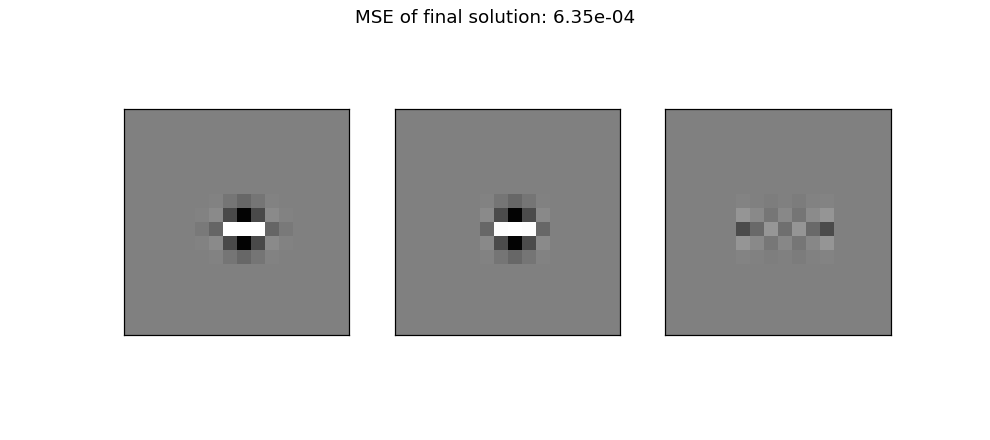

In [8]:
# Get the output by passing impulse to network
net = MyNet()
net.accept_weights(bestw)
y_hat = net(impulse16).detach().cpu().numpy()[0,0]
y_target = torch.tensor(xb[1], dtype=torch.float32, device=dev)  
y_target = ((y_target-y_target.mean())/y_target.std()).cpu().numpy()

# Plot
fig, ax = plt.subplots(1,3, figsize=(9,4),
                       subplot_kw={'xticks':[], 'yticks':[]})
ax[0].imshow(y_target, vmin=-5, vmax=5)
ax[1].imshow(y_hat, vmin=-5, vmax=5)
ax[2].imshow(y_target-y_hat, vmin=-.5, vmax=0.5)
fig.suptitle('MSE of final solution: {:.2e}'.format(
    np.mean((y_target - y_hat)**2)));

# Compare to parameterization as 1 5x5
We know this should be pretty much perfect, so how does the above compare to a 5x5?

<IPython.core.display.Javascript object>


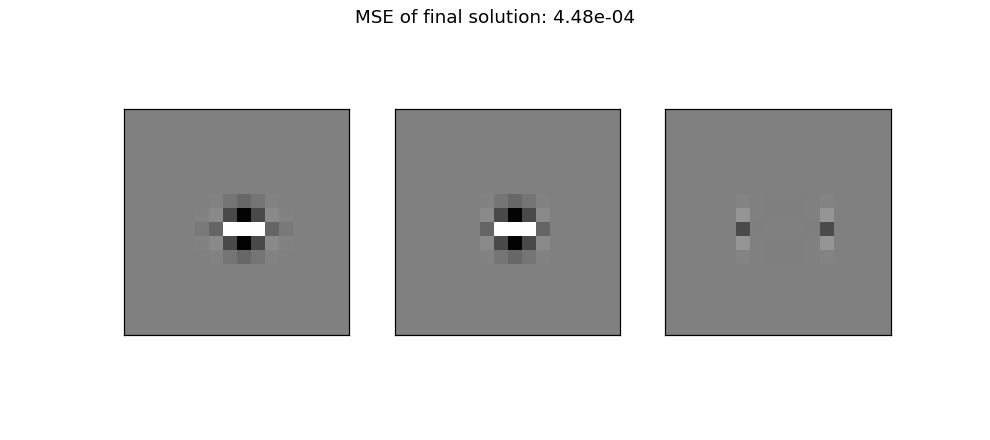

In [9]:
lbest, bestw_1_5x5_lh = find_ws(impulse16, xb[1], k=5, n=1, iters=100)

# Get the output by passing impulse to network
x = torch.zeros(1,1,16,16)
x[0,0,8,8] = 1
for w in bestw_1_5x5_lh:
    x = F.conv2d(x, torch.tensor(w), padding=w.shape[-1]//2)
y_hat = x.detach().cpu().numpy()[0,0]

fig, ax = plt.subplots(1,3, figsize=(9,4),
                       subplot_kw={'xticks':[], 'yticks':[]})
ax[0].imshow(y_target, vmin=-5, vmax=5)
ax[1].imshow(y_hat, vmin=-5, vmax=5)
ax[2].imshow(y_target-y_hat, vmin=-.5, vmax=0.5)

fig.suptitle('MSE of final solution: {:.2e}'.format(
    np.mean((y_target - y_hat)**2)));

# Compare to 3 3x3 kernels

<IPython.core.display.Javascript object>


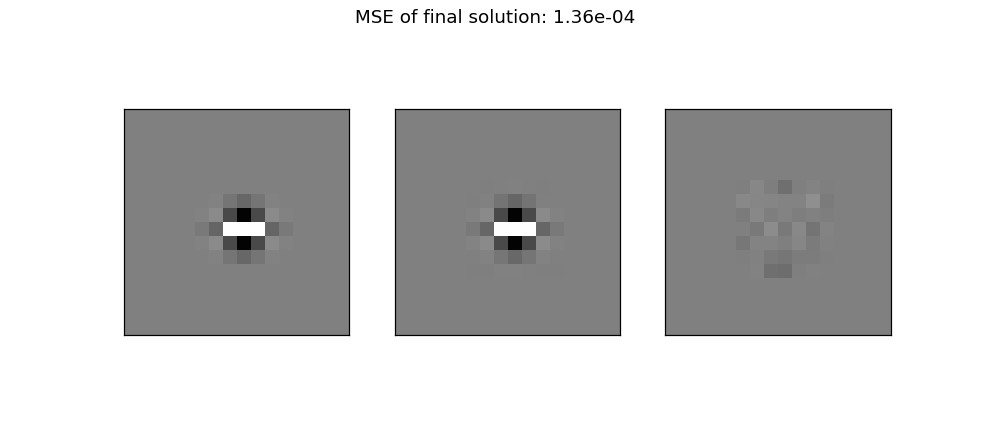

In [10]:
lbest, bestw_3_3x3_lh = find_ws(impulse16, xb[1], k=3, n=3, iters=100, λ=500)

# Get the output by passing impulse to network
net = MyNet()
net.accept_weights(bestw_3_3x3_lh)
y_hat = net(impulse16).detach().cpu().numpy()[0,0]
y_target = torch.tensor(xb[1], dtype=torch.float32, device=dev)  
y_target = ((y_target-y_target.mean())/y_target.std()).cpu().numpy()

# Plot
fig, ax = plt.subplots(1,3, figsize=(9,4),
                       subplot_kw={'xticks':[], 'yticks':[]})
ax[0].imshow(y_target, vmin=-5, vmax=5)
ax[1].imshow(y_hat, vmin=-5, vmax=5)
ax[2].imshow(y_target-y_hat, vmin=-.5, vmax=0.5)
fig.suptitle('MSE of final solution: {:.2e}'.format(
    np.mean((y_target - y_hat)**2)));

# Try a different filter
For finality, let us also try the ll filter. Again we'll go back to the design with 2 3x3 filters instead of 1 5x5 or 3 3x3's

<IPython.core.display.Javascript object>


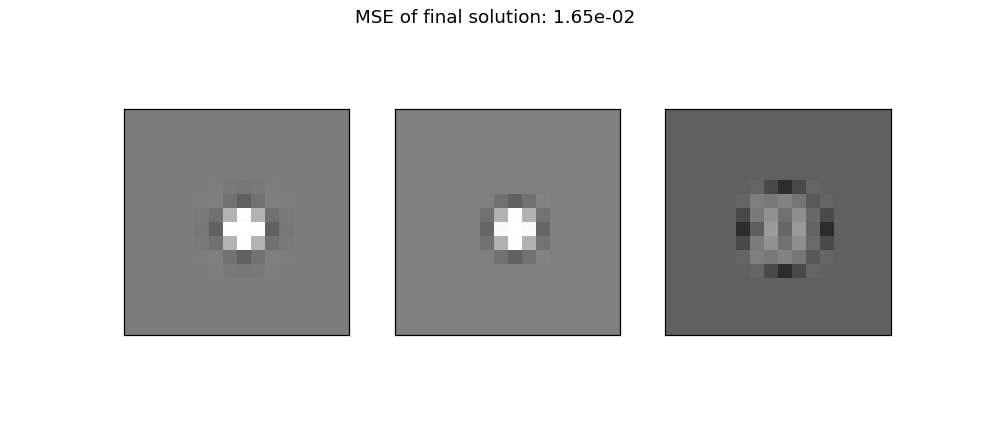

In [11]:
lbest, bestw_2_3x3_ll = find_ws(impulse16, xb[0], k=3, n=2, iters=100, λ=1000, λ2=0)

# Get the output by passing impulse to network
net = MyNet()
net.accept_weights(bestw_2_3x3_ll)
y_hat = net(impulse16).detach().cpu().numpy()[0,0]
y_target = torch.tensor(xb[0], dtype=torch.float32, device=dev)  
y_target = ((y_target-y_target.mean())/y_target.std()).cpu().numpy()

# Plot
fig, ax = plt.subplots(1,3, figsize=(9,4),
                       subplot_kw={'xticks':[], 'yticks':[]})
ax[0].imshow(y_target, vmin=-5, vmax=5)
ax[1].imshow(y_hat, vmin=-5, vmax=5)
ax[2].imshow(y_target-y_hat, vmin=-.5, vmax=0.5)
fig.suptitle('MSE of final solution: {:.2e}'.format(
    np.mean((y_target - y_hat)**2)));

# Conclusion
We have shown how it is possible to factorize some larger filters as convolutions of smaller filters. Note that we haven't discussed a lot of the hyperparameter search done for the different weight factors between MSE loss, l2 loss and admissibility as well as the learning rate. These are not necessarily easy to find, and some optimization may need to be done if repeating on your own filters.